<a href="https://colab.research.google.com/github/jorgealarconlucas/TFG/blob/master/TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Trabajo Fin de Grado </center> 
## <center> Análisis de la evolución de los Parámetros del Hemograma utilizando Random Forest en Pacientes Infectados con SARS-CoV-2  </center> 
#### <center> *Jorge Alarcón Lucas* </center>

El objetivo de estudio se centra en estudiar de manera evolutiva qué variables obtenidas por medio de hemogramas y qué variables relacionadas con la coagulación son especialmente importantes para el diagnóstico preventivo de infección SARS-CoV2. Para ello el target será el estado de "FALLECE" y "UCI" del paciente.

In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

# 1. Visualización de datos 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Antes de entrenar un modelo predictivo, o antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar un análisis descriptivo de los mismos. De esta forma, entender mejor la información que contiene cada variable y detectar posibles errores.

In [3]:
db = pd.read_csv('/content/Base datos COVID-Linfos Actualizazda.xlsx - Valores seleccionados.csv')

#Cambio las comas por puntos y de esa manera las columnas ya me salen float64, pero no se cambian las comas de las ultimas 4 columnas
#Sin embargo, si quito lo de las comas y puntos y lo añado mas adelante de otra manera, se cambian todas las comas por los puntos pero siguen
# tipo object

db.head(8)

,Número,Repetición NHC,Código Externo,FALLECE,UCI,Día del Año,19nCv,Día de POSITIVO,Días respecto a Positivo,Fecha,Edad del Paciente,Sexo del Paciente,GSRH,GRHPC,GRHRN,GRHCE,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,...,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ESSYS,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1
0,221.0,4,111561,NaN,NaN,90,NaN,NaN,NaN,30/03/20,85 años,M,NaN,O-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,319.0,13,102441,NaN,NaN,100,NaN,NaN,NaN,9/04/20,74 años,F,NaN,A-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,368.0,16,102441,NaN,NaN,104,NaN,NaN,NaN,13/04/20,74 años,F,NaN,A-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1759.0,9,104851,NaN,NaN,238,NaN,NaN,NaN,25/08/20,81 años,M,NaN,O+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,265277.0,7,11258,NaN,NaN,91,NaN,NaN,NaN,31/03/20,65 años,M,NaN,NaN,NaN,NaN,"5,57","2,55","45,8","2,27","40,8","0,47","8,4","0,23","4,1","0,04","0,7","0,01","0,2","5,31","15,7","46,3","87,2","29,6","33,9",13,0,0,NaN,NaN,...,896.0,430.0,"80,4","73,7","58,1",273.0,728.0,485.0,"120,9","122,2","63,9","50,2","154,8","2,55","45,8",291.0,557.0,521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,57",NaN,"5,77","5,57",NaN,NaN,0,0,"5,7","2,3","0,13","154,8","50,2",0,NaN
5,325932.0,11,115555,NaN,NaN,98,NaN,NaN,NaN,7/04/20,69 años,M,NaN,NaN,NaN,NaN,"7,03","3,84","54,7","2,26","32,1","0,76","10,8","0,11","1,6","0,05","0,7","0,01","0,1","5,73","15,3","47,8","83,4","26,7",32,"15,1",0,0,NaN,NaN,...,870.0,570.0,"80,7","70,1","57,9",273.0,786.0,650.0,"120,7",117,"64,6","47,8","147,1","3,84","54,7",313.0,565.0,654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7,03",NaN,"7,08","7,03",NaN,NaN,0,0,"6,6","2,1","0,15","147,1","47,8",0,NaN
6,366742.0,5,111520,NaN,NaN,83,NaN,NaN,NaN,23/03/20,77 años,F,NaN,NaN,NaN,NaN,"7,04","3,69","52,5","2,41","34,2","0,69","9,8","0,21",3,"0,03","0,4","0,01","0,1","4,83",14,"44,3","91,7",29,"31,6","14,8",0,0,NaN,NaN,...,853.0,572.0,"76,8","72,7",56,269.0,790.0,631.0,115,"113,9",65,"49,9","152,6","3,69","52,5",314.0,581.0,582.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7,04",NaN,"7,23","7,04",NaN,NaN,0,0,"5,4","1,8","0,13","152,6","49,9",0,NaN
7,374616.0,6,116651,NaN,NaN,97,NaN,NaN,NaN,6/04/20,70 años,F,NaN,NaN,NaN,NaN,"4,97","2,24",45,"2,18","43,9","0,47","9,5","0,05",1,"0,02","0,4","0,01","0,2","4,5","11,9",38,"84,4","26,4","31,3","15,5",0,0,NaN,NaN,...,934.0,623.0,81,"74,9","57,8",271.0,649.0,607.0,"121,6","120,3","67,5","52,7",150,"2,24",45,333.0,588.0,686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,97",NaN,"4,95","4,97",NaN,NaN,0,0,"11,5",5,"0,25",150,"52,7",0,NaN


In [4]:
db.head

<bound method NDFrame.head of        Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
0       221.0               4          111561  ...    NaN    NaN      NaN
1       319.0              13          102441  ...    NaN    NaN      NaN
2       368.0              16          102441  ...    NaN    NaN      NaN
3      1759.0               9          104851  ...    NaN    NaN      NaN
4    265277.0               7           11258  ...   50,2      0      NaN
..        ...             ...             ...  ...    ...    ...      ...
337  594293.0               5          128148  ...   47,6      0      NaN
338  594400.0               4          101609  ...   47,2      0      NaN
339  595190.0               6          138076  ...   54,7      0      NaN
340  597900.0               5          101609  ...   46,8      0      NaN
341  601867.0               7          101609  ...     47      0      NaN

[342 rows x 137 columns]>

In [5]:
Fallece = db.groupby(['FALLECE']).count() #0.0 son los NO fallecidos y 1.0 los fallecidos
print (Fallece)

         Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
FALLECE                                          ...                       
0.0          85              85              85  ...     53     53       45
1.0          11              11              11  ...      7      7        4

[2 rows x 136 columns]


In [6]:
UCI = db.groupby(['UCI']).count() #0.0 son los NO han entrado en UCI y 1.0 son los que han entrado en UCI
print (UCI)

     Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
UCI                                          ...                       
0.0      85              85              85  ...     55     55       41
1.0      11              11              11  ...      5      5        8

[2 rows x 136 columns]


### 1.1 ELIMINACION DE COLUMNAS Y FILAS

Tras una visualización general y una charla con los sanitarios que me han transferido la base de datos, llegamos a la conclusión de que hay que hacer una limpieza de la misma. Hay columnas que su significado y valores no tienen ninguna relevancia para el estudio que se va a llevar a cabo.

- Elimino una columna que aparece aqui pero NO en la base de datos original, "Día de POSITIVO".

In [7]:
db1=db.drop(["Repetición NHC","Día de POSITIVO","Días respecto a Positivo","GSRH","GRHPC","GRHRN","GRHCE"],axis=1) #axis=1 ya que lo que elimino son columnas.


Teniendo en cuenta que la prueba PCR se hace como máximo una vez a la semana, si se cita a un mismo paciente dos veces en una misma semana, lo normal es que en esa segunda cita solo se haga una analítica. Sin embargo en ocasiones hay filas que no tienen información ni en 19nCv ni en los distintos parámetros del hemograma, por lo que esas filas deben ser eliminadas. (Código que viene a continuación)

A continuación elimino las filas que no aportan información
(Quiero que me borre todas las filas en las que en todas las columnas que indico tengan valor Nan.)

In [8]:
db1= db1.dropna(thresh=9) #Mantiene solo las filas con al menos 9 valores que no sean NA. Esto me sirve ya que quiero eliminar aquellas filas
#que tengan NaN, es decir 19nCv y todos los parámetros del hemograma.
db1.shape

(320, 130)

### 1.2 AGRUPACION DE PACIENTES POR GRAVEDAD


- UCI=1 y FALLECE=1 --> Muy grave
- UCI=0 y FALLLECE=1 --> Muy grave

- UCI=1 y FALLECE=0 --> Grave
- UCI=0 y FALLECE=0 --> Sano

In [9]:
#counterFunc = db1.apply(
  #  lambda x: True if x(db1['UCI'] == 1.0) & (db1['FALLECE'] == 1.0) else False , axis=1)
#numOfRows = len(counterFunc[counterFunc == True].index)
#print('Row count is:',numOfRows)

In [10]:
data_all = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 1.0)]
data_death = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 1.0)]
data_regular = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 0.0)]
data_health = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 0.0)]

In [11]:
df_explicativo1 = pd.DataFrame({ #Creo un dataframe con el número de pacientes que cumple cada condición
  'Rows': [len(data_all.axes[0]), len(data_death.axes[0]), len(data_regular.axes[0]), len(data_health.axes[0])],
  }, index= ['1-1: MUY GRAVE', '0-1: MUY GRAVE', '1-0: REGULAR', '0-0: SANO'])

df_explicativo1

,Rows
1-1: MUY GRAVE,5
0-1: MUY GRAVE,6
1-0: REGULAR,6
0-0: SANO,79


Teniendo en cuenta cómo se reparte el número de pacientes en cada uno de los grupos, es decir se aprecia un desbalanceo, he decidido agrupar a los sano por una lado (sanos = 0) y por otro lado el resto de pacientes (grave = 1)

In [12]:
df_explicativo2 = pd.DataFrame({ #Creo un dataframe con el número de pacientes que cumple cada condición
  'Rows': [len(data_all.axes[0]) + len(data_death.axes[0]) + len(data_regular.axes[0]), len(data_health.axes[0])],
  }, index= ['1:Grave', '0: SANO'])

df_explicativo2

,Rows
1:Grave,17
0: SANO,79


### 1.3 TIPO DE CADA COLUMNA

In [13]:
db1.info(verbose=True, null_counts=True) #Hay un total de 342 filas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 4 to 341
Data columns (total 130 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Número             319 non-null    float64
 1   Código Externo     320 non-null    int64  
 2   FALLECE            96 non-null     float64
 3   UCI                96 non-null     float64
 4   Día del Año        320 non-null    int64  
 5   19nCv              105 non-null    object 
 6   Fecha              320 non-null    object 
 7   Edad del Paciente  320 non-null    object 
 8   Sexo del Paciente  320 non-null    object 
 9   LEU                284 non-null    object 
 10  NEU                284 non-null    object 
 11  NEUp               284 non-null    object 
 12  LIN                284 non-null    object 
 13  LINp               284 non-null    object 
 14  MON                284 non-null    object 
 15  MONp               284 non-null    object 
 16  EOS                284 no

- Una vez se analizan las columnas, se puede observar que aquellas columnas con valores númericos separados por comas son de tipo **object**, por lo que las comas deben ser reemplazadas por puntos.

- Se observa como la variable **Edad** se encuentra como **object** debido a que la edad de cada paciente ha sido registrada seguida de la palabra **años**. Por ello, se crea una función que permita eliminar dicha palabra y a su vez convertir la variable a tipo numérico. 

- También, se precisa de otras variables como **object** cuando deberian de ser numéricas debido a la presencia de "----" que hacen referencia a valores perdidos. Por tanto, aquellas variables que presenten este conjunto de caracteres serán reemplazados por NaN. 

- Finalmente, tras los cambios realizados, se crea un código capaz de transformas las columnas tipo **object** en tipo **numérico**

In [14]:
# Eliminación de columnas del hemograma que no aportan información
db1=db1.drop(["FRSP","COMHE","AVSBL","AVSPL","AVSRJ","AVNRB","ESSYS"],axis=1) #axis=1 ya que lo que elimino son columnas.

In [15]:
#Cambio de comas por puntos
db1 = db1.replace(',','.', regex=True)

#Reemplazo esos caracteres por NaN
db1=db1.replace("----",np.nan)

# Función que elimina la palabra años
def only_digits (txt):
  return "".join(c for c in txt if c.isdigit())

db1["Edad del Paciente"] = db1["Edad del Paciente"].map(only_digits)

## MUY IMPORTANTE. Conversión de variables excepto 19nCv, Fecha, Sexo del Paciente y 19nCv.1 
# Una vez hecho el cambio de comas por puntos y haber introducido NaN por "----", este código me transforma los 'object' en 'numerics'
for i in db1:
  if not (i=="19nCv" or i=="Fecha" or i=="Sexo del Paciente" or i=="19nCv.1"):
    if db1[i].dtypes == object:
      db1[i] = pd.to_numeric(db1[i])

#Paso la variable "fecha" de tipo object a tipo datatime, para poder tratar con ella como una fecha.
db1["Fecha"]=pd.to_datetime(db1["Fecha"])

In [16]:
db1.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 4 to 341
Data columns (total 123 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Número             319 non-null    float64       
 1   Código Externo     320 non-null    int64         
 2   FALLECE            96 non-null     float64       
 3   UCI                96 non-null     float64       
 4   Día del Año        320 non-null    int64         
 5   19nCv              105 non-null    object        
 6   Fecha              320 non-null    datetime64[ns]
 7   Edad del Paciente  320 non-null    int64         
 8   Sexo del Paciente  320 non-null    object        
 9   LEU                284 non-null    float64       
 10  NEU                284 non-null    float64       
 11  NEUp               284 non-null    float64       
 12  LIN                284 non-null    float64       
 13  LINp               284 non-null    float64       
 14  MON      

In [17]:
max_edad = db1['Edad del Paciente'].max() 
print("El paciente de mayor edad tiene:", max_edad,"años")

min_edad = db1['Edad del Paciente'].min() 
print("El paciente de menor edad tiene:", min_edad,"años")

El paciente de mayor edad tiene: 85 años
El paciente de menor edad tiene: 27 años


### 1.4 ¿CUANTOS PACIENTES HAY EN LA BASE DE DATOS?

-El número de pacientes lo puedo sacar de la columna "Código externo". 

  1) Convierto esa columna en lista

  2) Saco valores únicos en esa lista de duplicados

Con esta función consigo convertir la columna "Código Externo" en lista, para que de esa manera sea más manejable

In [18]:
Codigo_lista = db1['Código Externo'].tolist()
#print("La lista de la columna Código Externo es:\n", Codigo_lista,"\n",type(Codigo_lista))

In [19]:
from collections import Counter

print(Counter(Codigo_lista).keys())
#print(Counter(Codigo_lista).values()) #Esta función me da el número de veces que sale repetido un paciente,
                  #es decir, el número de pruebas diferentes que se le hacen (igual que la siguiente función)

print("El número de pacientes en la base de datos es:", len(set(Codigo_lista))) 
#Me da el número de valores únicos en una lista de duplicados = número de pacientes

dict_keys([11258, 115555, 111520, 116651, 130481, 107747, 132015, 11372, 108894, 109115, 112823, 108897, 116806, 101480, 118401, 118023, 116005, 109036, 116159, 119737, 109887, 135217, 112135, 131267, 105140, 111786, 104798, 117212, 109339, 126455, 114183, 1214, 122958, 116033, 121289, 123676, 115847, 124738, 115784, 135062, 108527, 13299, 105639, 123456, 104849, 137304, 112511, 123156, 136922, 11197, 134855, 10074, 107746, 111561, 117398, 117462, 102441, 126638, 101660, 123724, 105582, 133617, 10092, 111310, 111339, 131394, 110435, 127383, 12016, 110607, 128124, 119766, 104851, 124850, 133978, 119606, 121358, 120418, 130937, 104431, 138076, 136647, 132432, 112894, 114495, 13397, 106066, 128864, 109129, 110011, 134492, 114819, 137069, 1164, 116453, 122654, 128148, 101609])
El número de pacientes en la base de datos es: 98


In [20]:
code = Counter(Codigo_lista) #diccionario con el recuento de citas por paciente
lista = pd.DataFrame.from_dict(code, orient='index').reset_index() #convierto la variable "code" en dataframe
lista = lista.rename(columns={'index':'Código externo', 0:'Número de citas'})
lista

,Código externo,Número de citas
0,11258,3
1,115555,4
2,111520,3
3,116651,3
4,130481,2
...,...,...
93,1164,3
94,116453,4
95,122654,2
96,128148,4


<Figure size 720x1440 with 0 Axes>

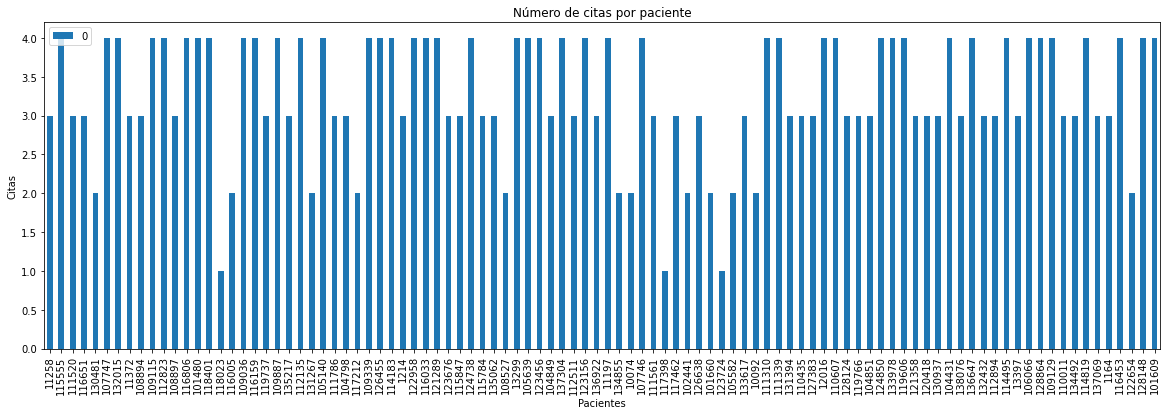

In [21]:
lista = pd.DataFrame.from_dict(code, orient='index')
plt.figure(figsize=(10,20))
lista.plot(kind='bar',figsize=(20,6), title='Número de citas por paciente', xlabel='Pacientes', ylabel='Citas') 
#es "bar" y no "hist" porque Counter está haciendo un recuento de frecuencia.

Una vez conozco el numero de citas de cada paciente, a continuación debo conseguir agrupar dichas citas y ordenarlas según "Fecha". Una vez conseguido, debo añadir una columna nueva indicando el número que corresponde a esa cita (1,2,3 o 4).

A continuación tengo que agrupar y ordenar las citas de cada uno de los pacientes. Posteriormente con ese agrupamiento podré crear 98 dataframes.

In [22]:
hola = db1.loc[db1["Código Externo"] == 137304]
hola = hola.sort_values('Fecha')
hola['Revision'] = range(1, 1+len(hola)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                        # en cuenta el número de citas de cada paciente.
hola

,Número,Código Externo,FALLECE,UCI,Día del Año,19nCv,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,...,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1,Revision
236,496041.0,137304,NaN,NaN,93,Positivo,2020-02-04,50,F,6.93,4.08,58.9,2.13,30.7,0.56,8.1,0.07,1.0,0.06,0.9,0.03,0.4,4.42,12.3,38.1,86.2,27.8,32.3,13.6,0.0,0.0,NaN,NaN,NaN,NaN,189.0,189.0,NaN,NaN,11.2,...,894.0,630.0,80.0,80.6,58.7,283.0,774.0,652.0,120.3,118.9,69.0,49.0,152.6,4.08,58.9,321.0,633.0,740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.93,NaN,7.13,6.93,NaN,0.0,0.0,14.6,4.5,0.31,152.6,49.0,0.0,NaN,1
111,407283.0,137304,0.0,0.0,86,Positivo,2020-03-26,50,F,6.58,3.60,54.6,2.30,35.0,0.59,9.0,0.01,0.2,0.04,0.6,0.04,0.6,4.95,13.4,41.3,83.4,27.1,32.4,13.9,0.0,0.0,NaN,NaN,NaN,NaN,151.0,151.0,NaN,NaN,10.9,...,1046.0,637.0,84.6,81.3,62.8,221.0,732.0,657.0,126.6,118.9,68.5,51.9,156.1,3.60,54.6,308.0,616.0,713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.58,NaN,6.82,6.58,NaN,0.0,0.0,25.2,8.8,0.58,156.1,51.9,0.0,NaN,2
162,411851.0,137304,NaN,NaN,90,NaN,2020-03-30,50,F,7.42,3.91,52.7,2.70,36.4,0.58,7.8,0.12,1.6,0.05,0.7,0.06,0.8,4.77,12.8,39.4,82.6,26.8,32.5,13.5,0.0,0.0,NaN,NaN,NaN,NaN,233.0,233.0,NaN,NaN,11.4,...,910.0,607.0,78.6,79.1,57.7,281.0,672.0,661.0,121.0,120.6,65.1,50.3,150.2,3.91,52.7,326.0,577.0,708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,NaN,7.46,7.42,NaN,0.0,0.0,14.4,5.3,0.39,150.2,50.3,0.0,NaN,3
237,496376.0,137304,NaN,NaN,99,NaN,2020-08-04,50,F,7.44,4.29,57.8,2.31,31.0,0.65,8.7,0.10,1.3,0.05,0.7,0.04,0.5,4.43,12.2,37.9,85.6,27.5,32.2,13.6,0.0,0.0,NaN,NaN,NaN,NaN,174.0,174.0,NaN,NaN,10.9,...,835.0,590.0,81.3,81.4,59.3,278.0,534.0,604.0,122.5,121.7,69.5,48.5,154.7,4.29,57.8,310.0,639.0,731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.44,NaN,7.51,7.44,NaN,0.0,0.0,14.3,4.4,0.33,154.7,48.5,0.0,NaN,4


In [23]:
empty_df = pd.DataFrame()

first = db1.loc[db1["Código Externo"] == 11258]
first = first.sort_values('Fecha')
first['Revision'] = range(1, 1+len(first)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                        # en cuenta el número de citas de cada paciente.

empty_df = empty_df.append(first)

In [24]:
lista_pacientes = Counter(Codigo_lista).keys()

for i in lista_pacientes:
    if i not in empty_df.values:
      new = db1.loc[db1["Código Externo"] == i]
      new = new.sort_values('Fecha')
      new['Revision'] = range(1, 1+len(new)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

      empty_df = empty_df.append(new)#cada vez que se itera se añade el df del paciente

    else:
      continue

empty_df

,Número,Código Externo,FALLECE,UCI,Día del Año,19nCv,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,...,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1,Revision
122,408196.0,11258,0.0,0.0,86,Positivo,2020-03-26,65,M,5.45,3.74,68.7,1.07,19.6,0.48,8.8,0.10,1.8,0.02,0.4,0.04,0.7,5.03,14.5,43.3,86.1,28.8,33.5,12.8,0.0,0.0,NaN,NaN,NaN,NaN,150.0,150.0,NaN,NaN,11.6,...,759.0,617.0,86.8,77.8,61.6,234.0,781.0,625.0,128.1,112.7,67.2,53.9,155.1,3.74,68.7,309.0,556.0,710.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.45,NaN,5.55,5.45,NaN,1.5,0.08,15.9,3.1,0.17,155.1,53.9,7.5,NaN,1
152,410679.0,11258,NaN,NaN,89,NaN,2020-03-29,65,M,5.01,2.68,53.5,1.42,28.3,0.58,11.6,0.22,4.4,0.03,0.6,0.08,1.6,4.86,13.6,41.6,85.6,28.0,32.7,12.5,0.0,0.0,NaN,NaN,NaN,NaN,235.0,235.0,NaN,NaN,11.0,...,968.0,480.0,78.8,78.5,56.3,240.0,761.0,477.0,120.9,127.4,60.8,49.8,149.9,2.68,53.5,307.0,542.0,569.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.01,NaN,5.13,5.01,NaN,0.0,0.00,16.2,4.6,0.23,149.9,49.8,0.0,NaN,2
4,265277.0,11258,NaN,NaN,91,NaN,2020-03-31,65,M,5.57,2.55,45.8,2.27,40.8,0.47,8.4,0.23,4.1,0.04,0.7,0.01,0.2,5.31,15.7,46.3,87.2,29.6,33.9,13.0,0.0,0.0,NaN,NaN,NaN,NaN,148.0,148.0,NaN,NaN,11.9,...,896.0,430.0,80.4,73.7,58.1,273.0,728.0,485.0,120.9,122.2,63.9,50.2,154.8,2.55,45.8,291.0,557.0,521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.57,NaN,5.77,5.57,NaN,0.0,0.00,5.7,2.3,0.13,154.8,50.2,0.0,NaN,3
180,414158.0,115555,NaN,NaN,93,NaN,2020-02-04,69,M,10.38,8.65,83.3,0.88,8.5,0.78,7.5,0.00,0.0,0.01,0.1,0.06,0.6,4.59,13.2,40.5,88.2,28.8,32.6,13.8,0.0,0.0,NaN,NaN,NaN,NaN,186.0,186.0,NaN,NaN,12.6,...,1071.0,599.0,84.1,68.2,58.5,242.0,640.0,726.0,119.6,106.3,62.0,48.3,143.9,8.65,83.3,320.0,600.0,694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.38,NaN,10.33,10.38,NaN,0.4,0.04,12.5,1.1,0.11,143.9,48.3,4.5,NaN,1
124,408493.0,115555,0.0,0.0,86,Positivo,2020-03-26,69,M,7.11,3.61,50.8,2.85,40.1,0.62,8.7,0.00,0.0,0.01,0.1,0.02,0.3,5.52,16.2,49.3,89.3,29.3,32.9,14.4,0.0,0.0,NaN,NaN,NaN,NaN,133.0,133.0,NaN,NaN,12.7,...,775.0,643.0,85.7,68.4,60.7,241.0,810.0,730.0,124.7,116.1,65.7,48.4,145.3,3.61,50.8,330.0,599.0,739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.11,NaN,6.92,7.11,NaN,0.0,0.00,3.2,1.3,0.09,145.3,48.4,0.0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,594293.0,128148,NaN,NaN,287,NaN,2020-10-13,56,F,10.71,7.97,74.3,1.87,17.5,0.78,7.3,0.01,0.1,0.01,0.1,0.07,0.7,4.36,13.2,39.4,90.4,30.3,33.5,13.2,0.0,0.0,NaN,NaN,NaN,NaN,254.0,254.0,NaN,NaN,12.6,...,901.0,586.0,79.7,75.4,61.5,227.0,676.0,619.0,123.4,115.4,71.1,47.6,151.5,7.97,74.3,330.0,651.0,699.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.71,NaN,10.73,10.71,NaN,0.0,0.00,7.0,1.2,0.13,151.5,47.6,0.0,NaN,4
335,591783.0,101609,0.0,0.0,281,Positivo,2020-07-10,28,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positivo,1
340,597900.0,101609,NaN,NaN,288,NaN,2020-10-14,28,M,9.63,5.17,53.7,2.51,26.1,0.88,9.1,0.38,3.9,0.15,1.6,0.54,5.6,5.32,14.5,43.3,81.4,27.3,33.5,15.3,0.0,0.0,NaN,NaN,NaN,NaN,424.0,424.0,NaN,NaN,8.9,...,899.0,420.0,81.1,72.3,59.6,252.0,637.0,535.0,122.8,109.9,65.5,46.8,154.5,5.17,53.7,324.0,535.0,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63,NaN,9.67,9.63,NaN,0.0,0.00,6.0,1.6,0.15,154.5,46.8,0.0,NaN,2
341,601867.0,101609,NaN,NaN,292,NaN,2020-10-18,28,M,6.59,2.97,45.1,2

**CUANDO CONSIGA PONER LA COLUMNA REVISION**, hago dos dataframes uno con sanos y otros con enfermos. A cada uno de esos dataframes añado un nueva columna "label". Los sanos tiene label=0 y los enfermos label=1. Esto me ayudará en mi siguiente paso que es plotear cada variable.

Ahora tengo que hacer que todas las revisiones del los pacientes sano tengan una nueva columna donde ponga 0 y todas las revisiones de los pacientes no sanos tengan una columna donde ponga 1.

In [25]:
lista_pacientes = Counter(Codigo_lista).keys()

### INICIALIZO DATAFRAME DE SANOS
sanos_df = pd.DataFrame()

### INICIALIZO DATAFRAME DE NO SANOS
no_sanos_df = pd.DataFrame()

for i in lista_pacientes:  
      if i not in data_health.values:
        new_1 = db1.loc[db1["Código Externo"] == i]
        new_1 = new_1.sort_values('Fecha')
        new_1['Revision'] = range(1, 1+len(new_1)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_1 = new_1.assign(label=1) #Introduzco nueva columna con etiqueta 1 (NO SANO)

        no_sanos_df = no_sanos_df.append(new_1)

      else:
        new_2 = db1.loc[db1["Código Externo"] == i]
        new_2 = new.sort_values('Fecha')
        new_2['Revision'] = range(1, 1+len(new_2)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_2 = new_2.assign(label=0)#Introduzco nueva columna con etiqueta 0 (SANO)
      
        sanos_df = sanos_df.append(new_2)


In [26]:
sanos_df

,Número,Código Externo,FALLECE,UCI,Día del Año,19nCv,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,...,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1,Revision,label
335,591783.0,101609,0.0,0.0,281,Positivo,2020-07-10,28,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positivo,1,0
340,597900.0,101609,NaN,NaN,288,NaN,2020-10-14,28,M,9.63,5.17,53.7,2.51,26.1,0.88,9.1,0.38,3.9,0.15,1.6,0.54,5.6,5.32,14.5,43.3,81.4,27.3,33.5,15.3,0.0,0.0,NaN,NaN,NaN,NaN,424.0,424.0,NaN,NaN,8.9,...,420.0,81.1,72.3,59.6,252.0,637.0,535.0,122.8,109.9,65.5,46.8,154.5,5.17,53.7,324.0,535.0,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63,NaN,9.67,9.63,NaN,0.0,0.0,6.0,1.6,0.15,154.5,46.8,0.0,NaN,2,0
341,601867.0,101609,NaN,NaN,292,NaN,2020-10-18,28,M,6.59,2.97,45.1,2.64,40.1,0.47,7.1,0.24,3.6,0.10,1.5,0.17,2.6,5.08,13.9,42.2,83.1,27.4,32.9,14.7,0.0,0.0,NaN,NaN,NaN,NaN,355.0,355.0,NaN,NaN,9.2,...,624.0,80.6,75.6,57.7,284.0,747.0,621.0,119.6,113.8,66.0,47.0,156.5,2.97,45.1,345.0,553.0,691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.59,NaN,6.63,6.59,NaN,0.0,0.0,7.2,2.9,0.19,156.5,47.0,0.0,NaN,3,0
338,594400.0,101609,NaN,NaN,286,NaN,2020-12-10,28,M,9.49,5.93,62.4,2.01,21.2,0.77,8.1,0.49,5.2,0.10,1.1,0.19,2.0,4.83,13.4,40.2,83.2,27.7,33.3,15.5,0.0,0.0,NaN,NaN,NaN,NaN,414.0,414.0,NaN,NaN,9.2,...,632.0,80.9,73.0,58.6,254.0,582.0,589.0,122.2,111.8,66.2,47.2,153.2,5.93,62.4,300.0,572.0,705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.49,NaN,9.40,9.49,NaN,0.0,0.0,7.5,1.6,0.15,153.2,47.2,0.0,NaN,4,0
335,591783.0,101609,0.0,0.0,281,Positivo,2020-07-10,28,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positivo,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,594400.0,101609,NaN,NaN,286,NaN,2020-12-10,28,M,9.49,5.93,62.4,2.01,21.2,0.77,8.1,0.49,5.2,0.10,1.1,0.19,2.0,4.83,13.4,40.2,83.2,27.7,33.3,15.5,0.0,0.0,NaN,NaN,NaN,NaN,414.0,414.0,NaN,NaN,9.2,...,632.0,80.9,73.0,58.6,254.0,582.0,589.0,122.2,111.8,66.2,47.2,153.2,5.93,62.4,300.0,572.0,705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.49,NaN,9.40,9.49,NaN,0.0,0.0,7.5,1.6,0.15,153.2,47.2,0.0,NaN,4,0
335,591783.0,101609,0.0,0.0,281,Positivo,2020-07-10,28,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positivo,1,0
340,597900.0,101609,NaN,NaN,288,NaN,2020-10-14,28,M,9.63,5.17,53.7,2.51,26.1,0.88,9.1,0.38,3.9,0.15,1.6,0.54,5.6,5.32,14.5,43.3,81.4,27.3,33.5,15.3,0.0,0.0,NaN,NaN,NaN,NaN,424.0,424.0,NaN,NaN,8.9,...,420.0,81.1,72.3,59.6,252.0,637.0,535.0,122.8,109.9,65.5,46.8,154.5,5.17,53.7,324.0,535.0,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63,NaN,9.67,9.63,NaN,0.0,0.0,6.0,1.6,0.15,154.5,46.8,0.0,NaN,2,0
341,601867.0,101609,NaN,NaN,292,NaN,2020-10-18,28,M,6.59,2.97,45.1,2.64,40.1,0.47,7.1,0.24,3.6,0.10,1.5,0.17,2.6,5.08,13.9,42.2,83.1,27.4,32.9,14.7,0.0,0.0,NaN,NaN,NaN,NaN,355.0,355.0,NaN,NaN,9.2,...,624.0,80.6,

In [28]:
#### SI NO PONGO ESTO A LO HORA DE REPRESENTAR ME DA ERROR
no_sanos_df.reset_index(drop=False, inplace = True)
sanos_df.reset_index(drop=False, inplace = True)

## REPRESENTACIÓN DE LOS DATOS (DataFrame)

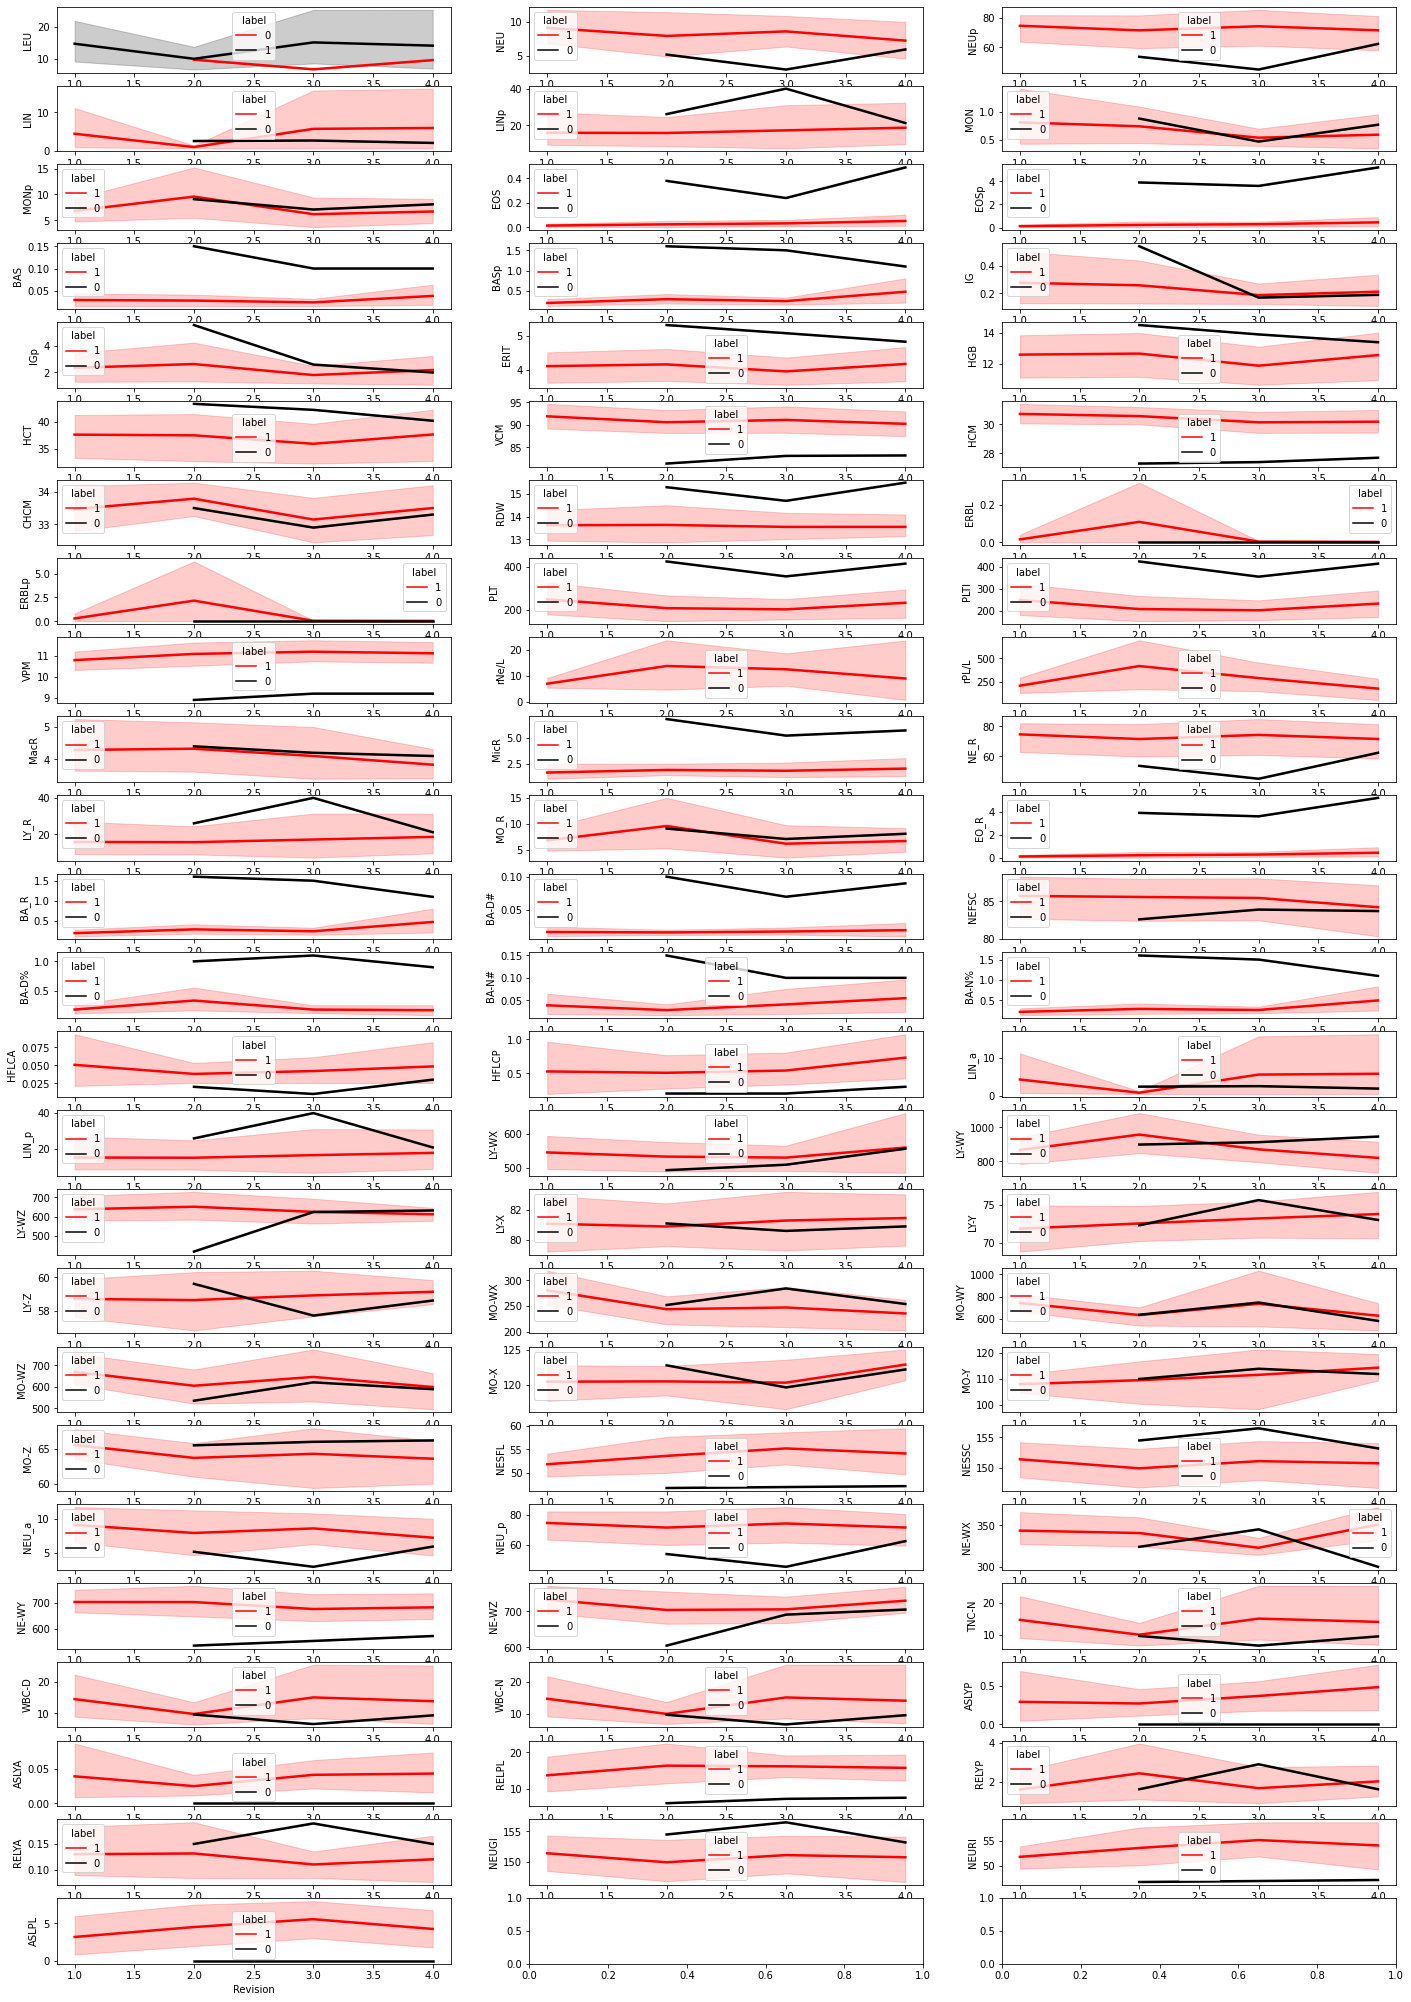

In [30]:
### LAS GRAFICAS ME SALEN RARAS

fig, axes = plt.subplots(25, 3, figsize=(24, 36)) #figsize = width x height

#fig.suptitle('Variables antes preproc ')


sns.lineplot(ax=axes[0, 0],data=no_sanos_df, x="Revision", y="LEU", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[0, 0],data=sanos_df, x="Revision", y="LEU", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[0, 1],data=no_sanos_df, x="Revision", y="NEU", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[0, 1],data=sanos_df, x="Revision", y="NEU", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[0, 2],data=no_sanos_df, x="Revision", y="NEUp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[0, 2],data=sanos_df, x="Revision", y="NEUp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[1, 0],data=no_sanos_df, x="Revision", y="LIN", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[1, 0],data=sanos_df, x="Revision", y="LIN", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[1, 1],data=no_sanos_df, x="Revision", y="LINp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[1, 1],data=sanos_df, x="Revision", y="LINp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[1, 2], data=no_sanos_df, x="Revision", y="MON", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[1, 2], data=sanos_df, x="Revision", y="MON", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[2, 0],data=no_sanos_df, x="Revision", y="MONp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[2, 0],data=sanos_df, x="Revision", y="MONp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[2, 1],data=no_sanos_df, x="Revision", y="EOS", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[2, 1],data=sanos_df, x="Revision", y="EOS", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[2, 2],data=no_sanos_df, x="Revision", y="EOSp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[2, 2],data=sanos_df, x="Revision", y="EOSp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[3, 0],data=no_sanos_df, x="Revision", y="BAS", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[3, 0],data=sanos_df, x="Revision", y="BAS", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[3, 1],data=no_sanos_df, x="Revision", y="BASp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[3, 1],data=sanos_df, x="Revision", y="BASp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[3, 2],data=no_sanos_df, x="Revision", y="IG", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[3, 2],data=sanos_df, x="Revision", y="IG", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[4, 0],data=no_sanos_df, x="Revision", y="IGp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[4, 0],data=sanos_df, x="Revision", y="IGp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[4, 1],data=no_sanos_df, x="Revision", y="ERIT", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[4, 1],data=sanos_df, x="Revision", y="ERIT", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[4, 2],data=no_sanos_df, x="Revision", y="HGB", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[4, 2],data=sanos_df, x="Revision", y="HGB", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[5, 0],data=no_sanos_df, x="Revision", y="HCT", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[5, 0],data=sanos_df, x="Revision", y="HCT", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[5, 1],data=no_sanos_df, x="Revision", y="VCM", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[5, 1],data=sanos_df, x="Revision", y="VCM", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[5, 2],data=no_sanos_df, x="Revision", y="HCM", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[5, 2],data=sanos_df, x="Revision", y="HCM", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[6, 0],data=no_sanos_df, x="Revision", y="CHCM", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[6, 0],data=sanos_df, x="Revision", y="CHCM", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[6, 1],data=no_sanos_df, x="Revision", y="RDW", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[6, 1],data=sanos_df, x="Revision", y="RDW", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[6, 2],data=no_sanos_df, x="Revision", y="ERBL", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[6, 2],data=sanos_df, x="Revision", y="ERBL", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[7, 0],data=no_sanos_df, x="Revision", y="ERBLp", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[7, 0],data=sanos_df, x="Revision", y="ERBLp", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[7, 1],data=no_sanos_df, x="Revision", y="PLT", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[7, 1],data=sanos_df, x="Revision", y="PLT", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[7, 2],data=no_sanos_df, x="Revision", y="PLTI", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[7, 2],data=sanos_df, x="Revision", y="PLTI", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[8, 0],data=no_sanos_df, x="Revision", y="VPM", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[8, 0],data=sanos_df, x="Revision", y="VPM", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[8, 1],data=no_sanos_df, x="Revision", y="rNe/L", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[8, 1],data=sanos_df, x="Revision", y="rNe/L", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[8, 2],data=no_sanos_df, x="Revision", y="rPL/L", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[8, 2],data=sanos_df, x="Revision", y="rPL/L", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[9, 0],data=no_sanos_df, x="Revision", y="MacR", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[9, 0],data=sanos_df, x="Revision", y="MacR", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[9, 1],data=no_sanos_df, x="Revision", y="MicR", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[9, 1],data=sanos_df, x="Revision", y="MicR", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[9, 2],data=no_sanos_df, x="Revision", y="NE_R", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[9, 2],data=sanos_df, x="Revision", y="NE_R", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[10, 0],data=no_sanos_df, x="Revision", y="LY_R", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[10, 0],data=sanos_df, x="Revision", y="LY_R", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[10, 1],data=no_sanos_df, x="Revision", y="MO_R", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[10, 1],data=sanos_df, x="Revision", y="MO_R", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[10, 2],data=no_sanos_df, x="Revision", y="EO_R", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[10, 2],data=sanos_df, x="Revision", y="EO_R", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[11, 0],data=no_sanos_df, x="Revision", y="BA_R", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[11, 0],data=sanos_df, x="Revision", y="BA_R", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[11, 1],data=no_sanos_df, x="Revision", y="BA-D#", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[11, 1],data=sanos_df, x="Revision", y="BA-D#", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[11, 2],data=no_sanos_df, x="Revision", y="NEFSC", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[11, 2],data=sanos_df, x="Revision", y="NEFSC", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[12, 0],data=no_sanos_df, x="Revision", y="BA-D%", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[12, 0],data=sanos_df, x="Revision", y="BA-D%", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[12, 1],data=no_sanos_df, x="Revision", y="BA-N#", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[12, 1],data=sanos_df, x="Revision", y="BA-N#", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[12, 2],data=no_sanos_df, x="Revision", y="BA-N%", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[12, 2],data=sanos_df, x="Revision", y="BA-N%", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[13, 0],data=no_sanos_df, x="Revision", y="HFLCA", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[13, 0],data=sanos_df, x="Revision", y="HFLCA", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[13, 1],data=no_sanos_df, x="Revision", y="HFLCP", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[13, 1],data=sanos_df, x="Revision", y="HFLCP", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[13, 2],data=no_sanos_df, x="Revision", y="LIN_a", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[13, 2],data=sanos_df, x="Revision", y="LIN_a", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[14, 0],data=no_sanos_df, x="Revision", y="LIN_p", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[14, 0],data=sanos_df, x="Revision", y="LIN_p", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[14, 1],data=no_sanos_df, x="Revision", y="LY-WX", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[14, 1],data=sanos_df, x="Revision", y="LY-WX", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[14, 2],data=no_sanos_df, x="Revision", y="LY-WY", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[14, 2],data=sanos_df, x="Revision", y="LY-WY", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[15, 0],data=no_sanos_df, x="Revision", y="LY-WZ", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[15, 0],data=sanos_df, x="Revision", y="LY-WZ", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[15, 1],data=no_sanos_df, x="Revision", y="LY-X", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[15, 1],data=sanos_df, x="Revision", y="LY-X", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[15, 2],data=no_sanos_df, x="Revision", y="LY-Y", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[15, 2],data=sanos_df, x="Revision", y="LY-Y", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[16, 0],data=no_sanos_df, x="Revision", y="LY-Z", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[16, 0],data=sanos_df, x="Revision", y="LY-Z", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[16, 1],data=no_sanos_df, x="Revision", y="MO-WX", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[16, 1],data=sanos_df, x="Revision", y="MO-WX", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[16, 2],data=no_sanos_df, x="Revision", y="MO-WY", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[16, 2],data=sanos_df, x="Revision", y="MO-WY", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[17, 0],data=no_sanos_df, x="Revision", y="MO-WZ", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[17, 0],data=sanos_df, x="Revision", y="MO-WZ", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[17, 1],data=no_sanos_df, x="Revision", y="MO-X", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[17, 1],data=sanos_df, x="Revision", y="MO-X", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[17, 2],data=no_sanos_df, x="Revision", y="MO-Y", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[17, 2],data=sanos_df, x="Revision", y="MO-Y", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[18, 0],data=no_sanos_df, x="Revision", y="MO-Z", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[18, 0],data=sanos_df, x="Revision", y="MO-Z", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[18, 1],data=no_sanos_df, x="Revision", y="NESFL", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[18, 1],data=sanos_df, x="Revision", y="NESFL", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[18, 2],data=no_sanos_df, x="Revision", y="NESSC", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[18, 2],data=sanos_df, x="Revision", y="NESSC", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[19, 0],data=no_sanos_df, x="Revision", y="NEU_a", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[19, 0],data=sanos_df, x="Revision", y="NEU_a", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[19, 1],data=no_sanos_df, x="Revision", y="NEU_p", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[19, 1],data=sanos_df, x="Revision", y="NEU_p", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[19, 2],data=no_sanos_df, x="Revision", y="NE-WX", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[19, 2],data=sanos_df, x="Revision", y="NE-WX", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[20, 0],data=no_sanos_df, x="Revision", y="NE-WY", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[20, 0],data=sanos_df, x="Revision", y="NE-WY", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[20, 1],data=no_sanos_df, x="Revision", y="NE-WZ", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[20, 1],data=sanos_df, x="Revision", y="NE-WZ", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[20, 2],data=no_sanos_df, x="Revision", y="TNC-N", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[20, 2],data=sanos_df, x="Revision", y="TNC-N", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[21, 0],data=no_sanos_df, x="Revision", y="WBC-D", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[21, 0],data=sanos_df, x="Revision", y="WBC-D", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[21, 1],data=no_sanos_df, x="Revision", y="WBC-N", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[21, 1],data=sanos_df, x="Revision", y="WBC-N", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[21, 2],data=no_sanos_df, x="Revision", y="ASLYP", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[21, 2],data=sanos_df, x="Revision", y="ASLYP", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[22, 0],data=no_sanos_df, x="Revision", y="ASLYA", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[22, 0],data=sanos_df, x="Revision", y="ASLYA", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[22, 1],data=no_sanos_df, x="Revision", y="RELPL", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[22, 1],data=sanos_df, x="Revision", y="RELPL", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[22, 2],data=no_sanos_df, x="Revision", y="RELYP", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[22, 2],data=sanos_df, x="Revision", y="RELYP", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[23, 0],data=no_sanos_df, x="Revision", y="RELYA", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[23, 0],data=sanos_df, x="Revision", y="RELYA", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[23, 1],data=no_sanos_df, x="Revision", y="NEUGI", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[23, 1],data=sanos_df, x="Revision", y="NEUGI", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[23, 2],data=no_sanos_df, x="Revision", y="NEURI", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[23, 2],data=sanos_df, x="Revision", y="NEURI", hue="label", palette=['black'], linewidth=2.5)

sns.lineplot(ax=axes[24, 0],data=no_sanos_df, x="Revision", y="ASLPL", hue="label", palette=['red'], linewidth=2.5)
sns.lineplot(ax=axes[24, 0],data=sanos_df, x="Revision", y="ASLPL", hue="label", palette=['black'], linewidth=2.5)

# 2. Identificacion de valores perdidos

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores perdidos son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

In [ ]:
db1.shape

In [ ]:
# Columnas con missing values

for index,value in enumerate (db1.isnull().sum()):
  if value !=0:
    print(db1.columns[index],value)

In [ ]:
#Quitar todas las columnas con mas de 332 NaN

db1=db1.dropna(thresh=10,axis=1) 

#342-333 = 9. Las columnas con 333 NaN tienen 9 valores no NaN. Por lo que si me quedo con aquellas columnas que tengan como mínimo 10 valores
# no NaN, elimino todas las columnas con 333 NaN o más.

In [ ]:
db1.shape #Ver como tratar las filas, lo que hable con Javier (OJOOOOOO)

Se han eliminado 40 variables debido a la presencia de mas de 333 valores perdidos por columna.

Tras la eliminación de las filas y columnas que no me interesan, finalmente me quedo con 337 filas y 83 columnas.

# 3. Identificación outliers

Para detectar los outliers el primer paso es realizar una inspección visual a través de los boxplots y localizar aquellos que sobresalen del rango normal de valores.

In [ ]:
db1.plot(kind='box',subplots=True, layout=(10,9), sharex=False, sharey=False, figsize=(30,30));